# Transverse Field Ising Model

We will simulate the Transverse Field Ising model using qiskit.

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import expm_multiply

In [2]:
# set up circuit for TFIM evolution
def apply_rz_gate(qc: QuantumCircuit, qubits: tuple[int, int], delta_t: float) :
    qc.cx(*qubits)
    qc.rz(2 * delta_t, qubits[1])
    qc.cx(*qubits)


# implements one trotter step
def make_trotter(num_qubits: int, delta_t: float) -> QuantumCircuit :
    qc = QuantumCircuit(num_qubits)
    h = Parameter("h")
    J = - 2
    for i in range(0, num_qubits - 1, 2) :
        apply_rz_gate(qc, (i, i + 1), J * delta_t)
    qc.barrier()
    for i in range(1, num_qubits - 1, 2) :
        apply_rz_gate(qc, (i, i + 1), J * delta_t)
    qc.barrier()
    for i in range(0, num_qubits) :
        qc.rx(2 * h * delta_t, i)
    qc.barrier()
    return qc

def make_circuit(num_qubits: int, delta_t: float, trotter_steps: int) -> QuantumCircuit :
    qc = QuantumCircuit(num_qubits)
    qc_append = make_trotter(num_qubits, delta_t)
    for _ in range(trotter_steps) :
        qc.compose(qc_append, inplace = True)
    return qc

In [3]:
# simulation parameters
num_qubits = 10
delta_t = 0.1
trotter_steps = 10

In [4]:
# this is the magnetization operator
magnetization_list = [('I' * (i - 1) + 'Z' + 'I' * (num_qubits - i), 1) for i in range(1, num_qubits + 1)]
observables = [SparsePauliOp.from_list(magnetization_list)]

In [5]:
# range of h values
params = np.arange(0.1, 10, 0.1)

In [6]:
estimator = StatevectorEstimator() # create an instance of the estimator

In [7]:
circuit = make_circuit(num_qubits, delta_t = 0.1, trotter_steps = 10)

In [8]:
pub = (circuit, observables, params) # primitive unified bloc

In [9]:
job = estimator.run([pub])

## Exact diagonalization

In [10]:
# --- Pauli matrices ---
def pauli():
    I = sparse.identity(2, format='csc')
    X = sparse.csc_matrix([[0,1],[1,0]], dtype=complex)
    Z = sparse.csc_matrix([[1,0],[0,-1]], dtype=complex)
    return I, X, Z

def embed(op, site, N):
    """Little-endian: site=0 acts on the rightmost factor (Qiskit qubit 0)."""
    I, *_ = pauli()
    factors = [I]*N
    factors[N-1-site] = op
    out = factors[0]
    for f in factors[1:]:
        out = sparse.kron(out, f, format='csc')
    return out

def ising_tf_hamiltonian(N, J, h):
    I, X, Z = pauli()
    H = sparse.csc_matrix((2**N, 2**N), dtype=complex)
    for i in range(N-1):
        H += J * embed(Z, i, N).dot(embed(Z, i+1, N))
    for i in range(N):
        H += h * embed(X, i, N)
    return H

def magnetization_z_op(N, normalize=True):
    _, _, Z = pauli()
    M = sparse.csc_matrix((2**N, 2**N), dtype=complex)
    for i in range(N):
        M += embed(Z, i, N)
    if normalize:
        M /= N
    return M

# --- Parameters ---
N = 10
J = -2.0
t = 1.6
params = np.arange(0.1, 10, 0.1)

# Initial state |0...0>
psi0 = np.zeros(2**N, dtype=complex)
psi0[0] = 1.0

# Observable
Mz_op = magnetization_z_op(N)

# Store results
Mz_vs_h = []

# --- Loop over h ---
for h in params:
    H = ising_tf_hamiltonian(N, J, h)
    psi_t = expm_multiply((-1j)*H*t, psi0)
    Mz_t = np.vdot(psi_t, Mz_op.dot(psi_t)).real
    Mz_vs_h.append(Mz_t)

Mz_vs_h = np.array(Mz_vs_h)

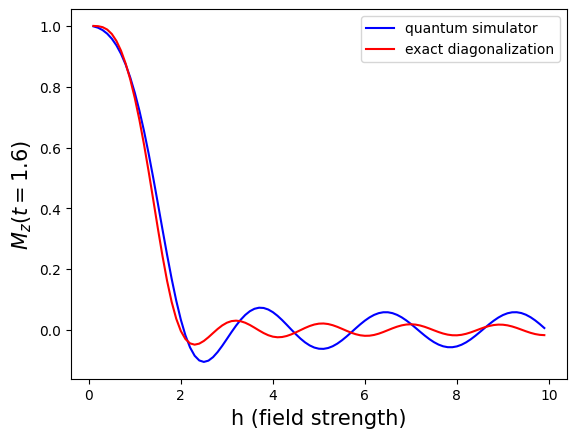

In [11]:
plt.plot(params, job.result()[0].data.evs / num_qubits, label = 'quantum simulator', color = 'blue')
plt.plot(params, Mz_vs_h, label = 'exact diagonalization', color = 'red')
plt.legend()
plt.xlabel('h (field strength)', size = 15)
plt.ylabel('$M_z(t = 1.6)$', size = 15)
plt.show()

# VQE

In [12]:
# Estimator circuit
theta = Parameter('theta')
zz_circuit = QuantumCircuit(num_qubits)

# unitary for the Z_iZ_{i + 1} interaction
def make_trotter_zz(num_qubits: int, theta: Parameter) -> QuantumCircuit :
    qc = QuantumCircuit(num_qubits)
    for i in range(0, num_qubits - 1, 2) :
        apply_rz_gate(qc, (i, i + 1), theta)
    qc.barrier()
    for i in range(1, num_qubits - 1, 2) :
        apply_rz_gate(qc, (i, i + 1), theta)
    qc.barrier()
    return qc
def make_trotter_x(num_qubits: int, theta: Parameter) -> QuantumCircuit :
    qc = QuantumCircuit(num_qubits)
    for i in range(0, num_qubits) :
        qc.rx(theta, i)
    return qc

In [13]:
# Objective function: expectation value
def objective(params):
    value = estimator.run([(qc, observable, {theta: params})]).result()[0].data.evs
    return value  # minimize this

# Step 4: Optimize using SciPy
res = minimize(objective, x0=[1.1], method='COBYLA')
print("Optimal θ:", res.x)
print("Minimized expectation value:", res.fun)

NameError: name 'minimize' is not defined

In [8]:
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize
import numpy as np

In [13]:
# Utilities
def pauli_str_from_ops(N, placements):
    """
    Build a Pauli string for N qubits.
    placements: dict {qubit_index:int -> 'I'/'X'/'Y'/'Z'}
    Qiskit uses little-endian strings: rightmost char is qubit 0.
    """
    s = ['I'] * N
    for q, letter in placements.items():
        s[q] = letter
    return "".join(s[::-1])  # reverse so index 0 is rightmost

def tfim_hamiltonian(N, J=1.0, h=0.5, periodic=False):
    terms = []
    # ZZ couplings
    for i in range(N):
        j = (i + 1) % N if periodic else i + 1
        if j < N:
            terms.append((pauli_str_from_ops(N, {i:'Z', j:'Z'}), J))
    # X field
    for i in range(N):
        terms.append((pauli_str_from_ops(N, {i:'X'}), h))
    return SparsePauliOp.from_list(terms)

def exact_ground_energy_tfim(N, J=1.0, h=0.5, periodic=False):
    # tiny ED for validation
    X = np.array([[0,1],[1,0]], complex)
    Z = np.array([[1,0],[0,-1]], complex)
    I = np.eye(2, dtype=complex)
    def kronN(mats):
        out = mats[0]
        for m in mats[1:]:
            out = np.kron(out, m)
        return out
    H = np.zeros((2**N, 2**N), complex)
    # ZZ
    for i in range(N):
        j = (i + 1) % N if periodic else i + 1
        if j < N:
            ops = [I]*N; ops[i]=Z; ops[j]=Z
            H += J*kronN(ops)
    # X
    for i in range(N):
        ops = [I]*N; ops[i]=X
        H += h*kronN(ops)
    w, _ = np.linalg.eigh(H)
    return float(np.min(w).real)


In [14]:
exact_ground_energy_tfim(10, 2, 0.1)

-18.015002736330448

## Operator pool

I am taking the following operator pool

\begin{equation}
O = \{Z_i Z_{i + 1}\,, X_i\,, Z_i\}_{i = 0}^{N - 1}
\end{equation}
The commutators of these with the Hamiltonian are
\begin{aligned}
O_i^{1} &:= [H, Z_iZ_{i+1}] &=& -2ih(Y_i Z_{i + 1} + Z_i Y_{i + 1})\\
O_i^{2} &:= [H, X_i] &=& 2iJ(Y_i Z_{i+1} + Z_{i-1}Y_i)\\
O_i^{3} &:= [H, Y_i] &=& 2 i h Z_i
\end{aligned}

In [84]:
# commutator of H with Z_i Z_{i + 1}
def operator_pool_O1(num_qubits: int, h: float):
    pool = []
    for i in range(num_qubits - 1):
        pauli_string = [('I' * i + 'YZ' + 'I' * (num_qubits - i - 2), 2 * h),
                        ('I' * i + 'ZY' + 'I' * (num_qubits - i - 2), 2 * h)]
        pool.append(SparsePauliOp.from_list(pauli_string))
    return pool

# commutator of H with X_i
def operator_pool_O2(num_qubits: int, J: float):
    pool = []
    pool.append(SparsePauliOp.from_list([('YZ' + 'I' * (num_qubits - 2), 2 * J)]))
    for i in range(1, num_qubits - 1):
        pauli_string = [('I' * i + 'YZ' + 'I' * (num_qubits - i - 2), 2*J),
                        ('I' * (i - 1) + 'ZY' + 'I' * (num_qubits - i - 1), 2*J)]
        pool.append(SparsePauliOp.from_list(pauli_string))
    return pool

# commutator of H with Y_i
def operator_pool_O3(num_qubits: int, h: float):
    pool = []
    for i in range(num_qubits):
        pauli_string = [('I' * i + 'Z' + 'I' * (num_qubits - i - 1), -2*h)]
        pool.append(SparsePauliOp.from_list(pauli_string))
    return pool

In [99]:
def gen_op_unitary_O1(qc, o_idx, param):
    qc.cx(o_idx, o_idx + 1)
    qc.rz(param, o_idx + 1)
    qc.cx(o_idx, o_idx + 1)

def gen_op_unitary_O2(qc, o_idx, param):
    qc.rx(param, o_idx)

def gen_op_unitary_O3(qc, o_idx, param):
    qc.ry(param, o_idx)

def gen_op_unitary(qc, pool_idx, o_idx, param):
    unitary_map = {0 : gen_op_unitary_O1, 1 : gen_op_unitary_O2, 2 : gen_op_unitary_O3}
    unitary_map[pool_idx](qc, o_idx, param)

In [151]:
def select_operator(pool, qc, estimator, params):
    """
    Select the operator with the largest gradient magnitude for ADAPT-VQE.

    Args:
        pool: list of operator pools [pool_O1, pool_O2, pool_O3]
        qc: current ansatz circuit
        estimator: StatevectorEstimator instance

    Returns:
        selected_op: SparsePauliOp with largest gradient magnitude
        max_grad: corresponding gradient magnitude
        pool_index: index of the pool in which the operator resides
        op_index: index of the operator within the pool
    """
    max_grad = - np.inf
    selected_op = None
    pool_index = -1
    op_index = -1

    for p_idx, operator_pool in enumerate(pool):
        if not operator_pool:
            continue

        job = estimator.run([(qc, operator_pool, params)])
        res = job.result()

        for o_idx, r in enumerate(res):
            try:
                grad_val = abs(r.data.evs)
            except AttributeError:
                grad_val = abs(r.values[0])

            # grad_val might be an array if multiple operators returned; pick the current index
            grad = grad_val[o_idx] if hasattr(grad_val, "__len__") else grad_val

            if grad > max_grad:
                max_grad = grad
                selected_op = operator_pool[o_idx]
                pool_index = p_idx
                op_index = o_idx

    return selected_op, max_grad, pool_index, op_index

In [221]:
from scipy.optimize import minimize

def run_vqe(num_qubits: int, J: float, h: float):
    pool = [operator_pool_O1(num_qubits, h),
            operator_pool_O2(num_qubits, J),
            operator_pool_O3(num_qubits, h)]
    
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    gradient = np.inf
    
    params_list = []     # Parameter objects
    param_values = []    # numeric values
    ops_list = []
    
    estimator = StatevectorEstimator()
    J_list = [('I' * i + 'ZZ' + 'I' * (num_qubits - i - 2), J) for i in range(num_qubits - 1)]
    h_list = [('I' * i + 'X' + 'I' * (num_qubits - i - 1), h) for i in range(num_qubits)]

    H = SparsePauliOp.from_list(J_list + h_list) # hamiltonian
    
    while gradient > -10:
        # 1. Select operator
        op, gradient, pool_idx, o_idx = select_operator(pool, qc, estimator, param_values)
        # print((pool_idx, o_idx))
        
        # 2. Add new Parameter + gate
        new_param = Parameter(f'theta_{len(params_list)}')
        gen_op_unitary(qc, pool_idx, o_idx, new_param)

        # Remove operator from pool list
        pool[pool_idx].pop(o_idx)
        if not pool[pool_idx]:  # if this sub-pool is empty
            pool.pop(pool_idx)
        
        # 3. Update lists
        params_list.append(new_param)
        param_values.append(0.0)  # initial guess for this new parameter
        ops_list.append(op)
        # print(param_values)

        # 4. Build objective function
        objective = make_objective(estimator, qc, H, params_list)  # <-- H = Hamiltonian is being minimized.
        
        # 5. Optimize starting from current param_values
        x0 = np.array(param_values, dtype=float)
        res = minimize(objective, x0, method='COBYLA')
        
        # 6. Update param_values from optimizer
        # print(res.x)
        param_values = list(res.x)
        
        # 7. Bind optimized parameters to circuit (optional)
        params_dict = dict(zip(params_list, param_values))
        # qc.assign_parameters(params_dict, inplace=True)
        # print('Assigned parameters')
        
        print(f"Iteration {len(params_list)}, max gradient = {gradient:.3e}, energy = {res.fun:.6f}")
    
    return params_list, param_values, ops_list


In [222]:
def make_objective(estimator, qc, H, params_order):
    def objective(x):
        bind = {p: float(v) for p, v in zip(params_order, x)}
        job = estimator.run([(qc, H, bind)])
        res = job.result()
        # Access expectation value; support both APIs if present
        try:
            val = float(res[0].data.evs)   # preferred in your setup
        except Exception:
            # fallback for other versions
            val = float(res.values[0])
        return val
    return objective

In [224]:
params_list, param_values, ops_list = run_vqe(num_qubits, -2, 1)

Iteration 1, max gradient = 0.000e+00, energy = -18.000000
Iteration 2, max gradient = 0.000e+00, energy = -18.000000
Iteration 3, max gradient = 0.000e+00, energy = -18.000000
Iteration 4, max gradient = 0.000e+00, energy = -18.000000
Iteration 5, max gradient = 0.000e+00, energy = -18.000000
Iteration 6, max gradient = 0.000e+00, energy = -18.000000
Iteration 7, max gradient = 0.000e+00, energy = -18.000000
Iteration 8, max gradient = 0.000e+00, energy = -18.000000
Iteration 9, max gradient = 0.000e+00, energy = -18.000000
Iteration 10, max gradient = 0.000e+00, energy = -18.000000
Iteration 11, max gradient = 0.000e+00, energy = -18.000000
Iteration 12, max gradient = 0.000e+00, energy = -18.000000
Iteration 13, max gradient = 0.000e+00, energy = -18.000000
Iteration 14, max gradient = 0.000e+00, energy = -18.000000
Iteration 15, max gradient = 0.000e+00, energy = -18.000000
Iteration 16, max gradient = 0.000e+00, energy = -18.000000
Iteration 17, max gradient = 0.000e+00, energy = 

KeyboardInterrupt: 

In [ ]:
def prep_GHZ(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    return qc

In [204]:
qc = prep_GHZ(10)

In [210]:
from qiskit.quantum_info import Statevector

In [196]:
param_values

[np.float64(-0.380526995795846),
 np.float64(0.003184116408548943),
 np.float64(-0.003208976311152893),
 np.float64(2.278038606190444e-05),
 np.float64(-0.003512753519938625),
 np.float64(0.003535533905932738),
 np.float64(0.035355339059327376),
 np.float64(-0.035355339059327376),
 np.float64(0.035355339059327376),
 np.float64(-0.035355339059327376),
 np.float64(0.0)]

In [198]:
params_list

[Parameter(theta_0),
 Parameter(theta_1),
 Parameter(theta_2),
 Parameter(theta_3),
 Parameter(theta_4),
 Parameter(theta_5),
 Parameter(theta_6),
 Parameter(theta_7),
 Parameter(theta_8),
 Parameter(theta_9),
 Parameter(theta_10)]

In [199]:
ops_list

[SparsePauliOp(['ZIIIIIIIII'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['IZIIIIIIII'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['IIZIIIIIII'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['IIIZIIIIII'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['IIIIZIIIII'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['IIIIIZIIII'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['IIIIIIZIII'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['IIIIIIIZII'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['IIIIIIIIZI'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['IIIIIIIIIZ'],
               coeffs=[-0.8+0.j]),
 SparsePauliOp(['YZIIIIIIII', 'ZYIIIIIIII'],
               coeffs=[0.8+0.j, 0.8+0.j])]

In [134]:
params_list

[np.float64(-0.04995839893103267)]

In [136]:
ops_list

[SparsePauliOp(['ZIIIIIIIII'],
               coeffs=[-0.2+0.j])]

In [162]:
# ----------------------------
# QAOA-style ansatz U = [exp(-i γ Σ ZZ) exp(-i β Σ X)]^p
# ----------------------------
def tfim_qaoa_ansatz(N, p=1, periodic=False):
    betas  = ParameterVector("β", p)
    gammas = ParameterVector("γ", p)
    deltas = ParameterVector("delta", p)
    qc = QuantumCircuit(N)
    # |+>^N
    # p layers
    for layer in range(p):
        γ = gammas[layer]
        # ZZ layer using CX-RZ-CX (implements exp(-i γ Z⊗Z))
        for i in range(N - 1):
            qc.cx(i, i+1)
            qc.rz(2*γ, i+1)    # factor 2 to match exp(-i γ Z Z)
            qc.cx(i, i+1)
        if periodic and N > 2:
            qc.cx(N-1, 0); qc.rz(2*γ, 0); qc.cx(N-1, 0)
        # X layer: RX(2β) implements exp(-i β X)
        β = betas[layer]
        for q in range(N):
            qc.rx(2*β, q)
        delta = deltas[layer]
        for j in range(N):
            qc.rz(range
    return qc, list(betas) + list(gammas)

# ----------------------------
# Objective (Estimator -> float via result[0].data.evs)
# ----------------------------
def make_objective(estimator, qc, H, params_order):
    def objective(x):
        bind = {p: float(v) for p, v in zip(params_order, x)}
        job = estimator.run([(qc, H, bind)])
        res = job.result()
        # Access expectation value; support both APIs if present
        try:
            val = float(res[0].data.evs)   # preferred in your setup
        except Exception:
            # fallback for other versions
            val = float(res.values[0])
        return val
    return objective

# ----------------------------
# Run VQE
# ----------------------------
def run_vqe_tfim(N=4, p=1, J=1.0, h=0.3, periodic=False, x0=None, method="COBYLA"):
    H = tfim_hamiltonian(N, J, h, periodic)
    qc, params_order = tfim_qaoa_ansatz(N, p, periodic)
    if x0 is None:
        x0 = np.zeros(2*p)  # [β_0..β_{p-1}, γ_0..γ_{p-1}]
    estimator = StatevectorEstimator()
    obj = make_objective(estimator, qc, H, params_order)
    res = minimize(obj, x0=x0, method=method)
    return res, H, qc, params_order

# ---- Example ----
if __name__ == "__main__":
    N, J, h, p = 5, 1.5, 0.1, 10
    res, H, qc, params = run_vqe_tfim(N=N, p=p, J=J, h=h, periodic=False, x0=None, method="COBYLA")
    print("Optimal params [β..., γ...]:", res.x)
    print("VQE energy:", res.fun)
    print("Exact E0  :", exact_ground_energy_tfim(N, J, h, periodic=False))


SyntaxError: '(' was never closed (188802289.py, line 26)